Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

## Map reduce

In [13]:
from time import sleep
def f(x):
    sleep(1)
    return x*x
L = list(range(8))
L

[0, 1, 2, 3, 4, 5, 6, 7]

In [14]:
%time sum([f(x) for x in L])

CPU times: user 906 µs, sys: 1.4 ms, total: 2.31 ms
Wall time: 8.02 s


140

In [15]:
%time sum(map(f,L))

CPU times: user 991 µs, sys: 1.52 ms, total: 2.51 ms
Wall time: 8.02 s


140

We can process each f calls independently and in parallel.  To accomplish this we'll apply that function f across all list items in parallel using multiple processes.


## Thread and Process: Differences

- A Process is an instance of a running program. 
- Process may contain one or more threads, but a thread cannot contain a process.
- Process has a self-contained execution environment. It has its own memory space. 
- Application running on your computer may be a set of cooperating processes.

- A Thread is made of and exist within a Process; every process has at least one. 
- Multiple threads in a process share resources, which helps in efficient communication between threads.
- Threads can be concurrent on a multi-core system, with every core executing the separate threads simultaneously.



## Multi-Processing vs Multi-Threading

### Memory
- Each process has its own copy of the data segment of the parent process.
- Each thread has direct access to the data segment of its process.
- A process runs in separate memory spaces.
- A thread runs in shared memory spaces.

### Communication
- Processes must use inter-process communication to communicate with sibling processes.
- Threads can directly communicate with other threads of its process.

### Overheads
- Processes have considerable overhead.
- Threads have almost no overhead.

## Multi-Processing vs Multi-Threading

### Creation
- New processes require duplication of the parent process.
- New threads are easily created.  

### Control
- Processes can only exercise control over child processes.
- Threads can exercise considerable control over threads of the same process.

### Changes
- Any change in the parent process does not affect child processes.
- Any change in the main thread may affect the behavior of the other threads of the process.


## The Global Interpreter Lock (GIL)

- The Python interpreter is not thread safe.
- A few critical internal data structures may only be accessed by one thread at a time. Access to them is protected by the GIL.
- Attempts at removing the GIL from Python have failed until now. The main difficulty is maintaining the C API for extension modules.
- Multiprocessing avoids the GIL by having separate processes which each have an independent copy of the interpreter data structures.
- The price to pay: serialization of tasks, arguments, and results.

# Multiprocessing (history)

- The multiprocessing allows the programmer to fully leverage multiple processors. 
- It runs on both Unix and Windows.
- The `Pool` object parallelizes the execution of a function across multiple input values.
- The if `__name__ == '__main__'` part is necessary.
<p><font color=red> The next cell could not work on Windows </font></p>
Try to add 
```python
sys.argv = ['c:/pathToScript/script.py']
multiprocessing.set_executable('C:/PathToMiniconda/bin/python.exe')
```

In [16]:
%%time
from multiprocessing import Pool

if __name__ == '__main__': # Executed only on main process.
    with Pool(4) as p:
        result = sum(p.map(f, L))
result

CPU times: user 7.67 ms, sys: 14.6 ms, total: 22.3 ms
Wall time: 2.08 s


# Futures

The `concurrent.futures` module provides a high-level interface for asynchronously executing callables.

The asynchronous execution can be performed with threads, using ThreadPoolExecutor, or separate processes, using ProcessPoolExecutor. Both implement the same interface, which is defined by the abstract Executor class.

In [17]:
%%time
from concurrent.futures import ProcessPoolExecutor
# from loky import ProcessPoolExecutor  # for Windows users 


def f(x):
    sleep(1)
    return x*x

e = ProcessPoolExecutor()

results = list(e.map(f, range(8)))

CPU times: user 11.8 ms, sys: 24.4 ms, total: 36.2 ms
Wall time: 1.03 s


In [18]:
%%time
from concurrent.futures import ThreadPoolExecutor

def f(x):
    sleep(1)
    return x*x

e = ThreadPoolExecutor()

results = list(e.map(f, range(8)))

CPU times: user 3.47 ms, sys: 4.61 ms, total: 8.08 ms
Wall time: 1.01 s


# Asynchronous Future
While many parallel applications can be described as maps, some can be more complex. In this section we look at the asynchronous Future interface, which provides a simple API for ad-hoc parallelism. This is useful for when your computations don't fit a regular pattern.


### Executor.submit

The `submit` method starts a computation in a separate thread or process and immediately gives us a `Future` object that refers to the result.  At first, the future is pending.  Once the function completes the future is finished. 

We collect the result of the task with the `.result()` method,
which does not return until the results are available.

In [19]:
from time import sleep

def slowadd(a, b, delay=1):
    sleep(delay)
    return a + b

In [20]:
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(4)
future = e.submit(slowadd, 1, 2)
future

<Future at 0x10e89dc50 state=running>

In [21]:
future.result()

3

Submit many tasks all at once and they be will executed in parallel.

In [22]:
%%time
results = [slowadd(i, i, delay=1) for i in range(8)]

CPU times: user 858 µs, sys: 1.14 ms, total: 2 ms
Wall time: 8.02 s


In [23]:
%%time
futures = [e.submit(slowadd, 1, 1, delay=1) for i in range(8)]
results = [f.result() for f in futures]

CPU times: user 1.79 ms, sys: 2.33 ms, total: 4.12 ms
Wall time: 2.01 s


*  Submit fires off a single function call in the background, returning a future.  
*  When you combine submit with a single for loop we recover the functionality of map.  
*  To collect your results, replace each of futures, `f`, with a call to `f.result()`
*  Combine submit with multiple for loops and other general programming to get something more general than map.
*  Sometimes, it did not speed up the code very much
*  Threads and processes show some performance differences
*  Use threads carefully, you can break your Python session.

Today most library designers are coordinating around the concurrent.futures interface, so it's wise to move over.

* Profile your code
* Used concurrent.futures.ProcessPoolExecutor for simple parallelism 
* Gained some speed boost (but not as much as expected)
* Lost ability to diagnose performance within parallel code
* Describing each task as a function call helps use tools like map for parallelism
* Making your tasks fast is often at least as important as parallelizing your tasks.

### Exercise: Pi computation

Parallelize this computation with a ProcessPoolExecutor. ThreadPoolExecutor is not usable because of `random` function calls.

In [24]:
# Serial version

import time, random
def compute_pi(n):
    count = 0
    for i in range(n):
        x=random.random()
        y=random.random()
        if x*x + y*y <= 1: count+=1
    return count
    
elapsed_time = time.time()
nb_simulations = 4
n = 10**7
result = []
for i in range(nb_simulations): # launch 4 simulations
    result.append(compute_pi(n))
pi = 4* sum(result)/ (n*nb_simulations)
print ("Estimated value of Pi : {0:.8f} time : {1:.8f}".format(pi,time.time()-elapsed_time))

Estimated value of Pi : 3.14173600 time : 13.55839324


<button data-toggle="collapse" data-target="#sol1" class='btn btn-primary'>Solution with map</button>
<div id="sol1" class="collapse">
```python
import time, random, math
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor

def compute_pi(n):
    count = 0
    for i in range(n):
        x=random.random()
        y=random.random()
        if x*x + y*y <= 1: count+=1
    return count

times = []
for np in range(1,cpu_count()+1):
    elapsed_time = time.time()
    n = 4 * 10**7
    part_count=[n//np] * np
    with ProcessPoolExecutor(np) as pool: 
        count=pool.map(compute_pi, part_count)
    pi = 4*sum(count)/n
    print ("Number of cores {0}, Error : {1:.8f}"
       " time : {2:.8f}".format(np, abs(pi-math.pi) ,time.time()-elapsed_time))
    times.append(time.time()-elapsed_time)
    
```

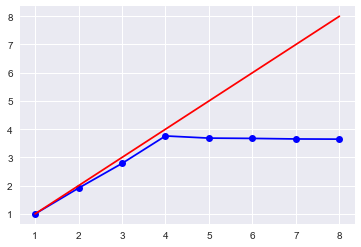

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
procs = [p+1 for p in range(len(times))]
etimes = [times[0]/t for t,p in zip(times,procs)]
plt.plot(procs,etimes,'b-o', procs, procs, 'r-');

<button data-toggle="collapse" data-target="#sol2" class='btn btn-primary'>Solution with submit</button>
<div id="sol2" class="collapse">
```python
import time, random
from concurrent.futures import ProcessPoolExecutor
def compute_pi(n):
    count = 0
    for i in range(n):
        x=random.random()
        y=random.random()
        if x*x + y*y <= 1: count+=1
    return count
    
elapsed_time = time.time()
np = 4
n = 10**7

pool = ProcessPoolExecutor()

futures = [pool.submit(compute_pi,n)] * np

results = [f.result() for f in futures]
    
pi = 4* sum(results)/ (n*np)
print ("Estimated value of Pi : {0:.8f} time : {1:.8f}".format(pi,time.time()-elapsed_time))
```

# Joblib (bonus)

[Joblib](http://pythonhosted.org/joblib/) provides a simple helper class to write parallel for loops using multiprocessing. 


In [30]:
%%time
from joblib import Parallel, delayed
Parallel(n_jobs=8)(delayed(f)(x) for x in range(8))

CPU times: user 45.6 ms, sys: 26.9 ms, total: 72.5 ms
Wall time: 1.1 s


<button data-toggle="collapse" data-target="#sol3" class='btn btn-primary'>Solution with joblib</button>
<div id="sol3" class="collapse">
```python
%%time
from joblib import Parallel, delayed

np = 4
n  = 10**7
part_count = [n] * np
result = Parallel(n_jobs=np)(delayed(compute_pi)(i) for i in part_count)

pi = 4* sum(result)/ n

print ("Estimated value of Pi : {0:.8f}".format(pi))
```

In [1]:
def laplacian(T):
    Told = T[1:-1, 1:-1]
    Tnew = (T[1:-1,2:]+T[2:,1:-1]+T[1:-1,:-2]+T[:-2,1:-1])/4.0
    Tmask = Tnew > 0.0
    residual = (numpy.repeat(numpy.fabs(Told-Tnews).flat,
                             Tmask.flat) / \
                numpy.repeat(Tnew.flat, Tmask.flat)).max()
    return Tnew, residual

def laplacian_parallel(T, n, pool):d
    d = min(7, n-2) # partition must be optimized ...
    # Make slices of equal size
    slices_jmin = numpy.arange(1, n-1, d)    
    slices_jmax = numpy.minimum(slices_jmin + d, n-1)
    # slice size must be > 1
    slices_jmin = numpy.minimum(slices_jmin, slices_jmax-1)
    # submit all tasks
    slices = pool.map(laplacian, [T[:, jmin-1:jmax+1]
                                  for jmin, jmax in zip(slices_jmin,
                                                        slices_jmax)])
    # cmpute residual
    self._residual = max(t[1] for t in slices)
    # copie new temperature values in  T
    for jmin, jmax, (apres, _)  in zip(slices_jmin, slices_jmax, slices):
      T[1:-1, jmin:jmax] = Tnew
    return residual